In [75]:
import google.colab
import os
from google.colab import files
uploaded = files.upload()

Saving strategy_df_window9.csv to strategy_df_window9.csv


In [30]:
df = pd.read_csv("strategy_df_window3.csv")
df.head()

,Ticker,Earnings_Date,Date,Days_From_Earnings,Open,Close,Next_Day_Open,Regular_Change%,After_Hours_Change%,EPS_Actual,EPS_Estimate,EPS_Surprise,EPS_Surprise_%,Sector,Industry,Profitable,Founder_is_CEO,FemaleCEO,Growth_in_Jobs
0,AAPL,2018-11-01,2018-10-12,-3,41.250000,42.400002,41.250000,2.787882,-2.712268,0.73,0.7,0.03,4.2857,Technology,"Computers, Office Equipment",yes,no,no,no
1,AAPL,2018-11-01,2018-10-12,-2,41.250000,42.400002,41.250000,2.787882,-2.712268,0.73,0.7,0.03,4.2857,Technology,"Computers, Office Equipment",yes,no,no,no
2,AAPL,2018-11-01,2018-10-12,-1,41.250000,42.400002,43.647499,2.787882,2.942211,0.73,0.7,0.03,4.2857,Technology,"Computers, Office Equipment",yes,no,no,no
3,AAPL,2018-11-01,2018-11-01,0,43.647499,43.820000,43.647499,0.395213,-0.393657,0.73,0.7,0.03,4.2857,Technology,"Computers, Office Equipment",yes,no,no,no
4,AAPL,2018-11-01,2018-11-01,1,43.647499,43.820000,43.647499,0.395213,-0.393657,0.73,0.7,0.03,4.2857,Technology,"Computers, Office Equipment",yes,no,no,no


In [11]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import train_test_split

# Load your dataset
df = pd.read_csv("strategy_df_window3.csv")

# === Step 1: Create Targets ===
df['target_pct_change'] = (df['Next_Day_Open'] - df['Close']) / df['Close'] * 100
df['target_direction'] = (df['target_pct_change'] > 0).astype(int)
df = df.drop_duplicates()

# === Step 2: Feature Selection ===
features = [
    'Open', 'Close', 'Regular_Change%', 'After_Hours_Change%',
    'EPS_Actual', 'EPS_Estimate', 'EPS_Surprise', 'EPS_Surprise_%', 'Days_From_Earnings'
]
X = df[features]
y_reg = df['target_pct_change']
y_clf = df['target_direction']

# === Step 3: Train/Test Split ===
from sklearn.model_selection import train_test_split

# Updated train-test split
X_train, X_test, y_reg_train, y_reg_test, y_clf_train, y_clf_test, idx_train, idx_test = train_test_split(
    X, y_reg, y_clf, df.index, test_size=0.3, random_state=42
)

# Use .loc to retrieve matching rows from the original DataFrame
test_df = df.loc[idx_test].copy()


# === Step 4: Train Models ===
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_reg = XGBRegressor(n_estimators=100, random_state=42, verbosity=0)

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_clf = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')

rf_reg.fit(X_train, y_reg_train)
xgb_reg.fit(X_train, y_reg_train)
rf_clf.fit(X_train, y_clf_train)
xgb_clf.fit(X_train, y_clf_train)

# === Step 5: Predictions ===
y_reg_pred_rf = rf_reg.predict(X_test)
y_reg_pred_xgb = xgb_reg.predict(X_test)
y_clf_pred_rf = rf_clf.predict(X_test)
y_clf_pred_xgb = xgb_clf.predict(X_test)

# === Step 6: Entry Signals ===
entry_signal_clf = (y_clf_pred_rf == 1) & (y_clf_pred_xgb == 1)
entry_signal_reg = (y_reg_pred_rf > 0.5) & (y_reg_pred_xgb > 0.5)

# === Step 7: Backtest ===
test_df = df.loc[X_test.index].copy()
test_df["Entry_Clf"] = entry_signal_clf
test_df["Entry_Reg"] = entry_signal_reg
test_df["Realized_Return_%"] = (test_df["Next_Day_Open"] - test_df["Close"]) / test_df["Close"] * 100

# Apply strategy
test_df["Strategy_Return_Clf"] = test_df["Entry_Clf"] * test_df["Realized_Return_%"]
test_df["Strategy_Return_Reg"] = test_df["Entry_Reg"] * test_df["Realized_Return_%"]

test_df["Cumulative_Clf"] = test_df["Strategy_Return_Clf"].cumsum()
test_df["Cumulative_Reg"] = test_df["Strategy_Return_Reg"].cumsum()

# === Step 8: Show Results ===
print("📊 Classification-Based Strategy")
print(f"Total Trades: {int(test_df['Entry_Clf'].sum())}")
print(f"Cumulative Return (%): {test_df['Cumulative_Clf'].iloc[-1]:.2f}\n")

print("📈 Regression-Based Strategy")
print(f"Total Trades: {int(test_df['Entry_Reg'].sum())}")
print(f"Cumulative Return (%): {test_df['Cumulative_Reg'].iloc[-1]:.2f}")


📊 Classification-Based Strategy
Total Trades: 1395
Cumulative Return (%): 4917.89

📈 Regression-Based Strategy
Total Trades: 980
Cumulative Return (%): 4812.87


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:41:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [12]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split


strategy_df_3d = pd.read_csv("strategy_df_window3.csv")

# STEP 1: Create Targets
strategy_df_3d['target_pct_change'] = (strategy_df_3d['Next_Day_Open'] - strategy_df_3d['Close']) / strategy_df_3d['Close'] * 100
strategy_df_3d['target_direction'] = (strategy_df_3d['target_pct_change'] > 0).astype(int)
strategy_df_cleaned = strategy_df_3d.drop_duplicates()

# STEP 2: Define Features and Targets
features = [
    'Open', 'Close', 'Regular_Change%', 'After_Hours_Change%',
    'EPS_Actual', 'EPS_Estimate', 'EPS_Surprise', 'EPS_Surprise_%', 'Days_From_Earnings'
]
X = strategy_df_cleaned[features]
y_reg = strategy_df_cleaned['target_pct_change']
y_clf = strategy_df_cleaned['target_direction']

# STEP 3: Split Data
X_train, X_test, y_reg_train, y_reg_test, y_clf_train, y_clf_test = train_test_split(
    X, y_reg, y_clf, test_size=0.3, random_state=42
)

# STEP 4: Initialize XGBoost Models (optimized for speed)
xgb_reg = XGBRegressor(n_estimators=50, random_state=42, verbosity=0)
xgb_clf = XGBClassifier(n_estimators=50, random_state=42, eval_metric='logloss')

# STEP 5: Train Models
xgb_reg.fit(X_train, y_reg_train)
xgb_clf.fit(X_train, y_clf_train)

# STEP 6: Predict
y_reg_pred_xgb = xgb_reg.predict(X_test)
y_clf_pred_xgb = xgb_clf.predict(X_test)

# STEP 7: Generate Entry Signals
entry_signal_clf = (y_clf_pred_xgb == 1)
entry_signal_reg = (y_reg_pred_xgb > 0.5)

# STEP 8: Simulate Trades
test_df = strategy_df_cleaned.loc[X_test.index].copy()
test_df["Entry_Clf"] = entry_signal_clf
test_df["Entry_Reg"] = entry_signal_reg
test_df["Realized_Return_%"] = (test_df["Next_Day_Open"] - test_df["Close"]) / test_df["Close"] * 100
test_df["Strategy_Return_Clf"] = test_df["Entry_Clf"] * test_df["Realized_Return_%"]
test_df["Strategy_Return_Reg"] = test_df["Entry_Reg"] * test_df["Realized_Return_%"]
test_df["Cumulative_Clf"] = test_df["Strategy_Return_Clf"].cumsum()
test_df["Cumulative_Reg"] = test_df["Strategy_Return_Reg"].cumsum()

# STEP 9: Results Summary
print("📊 XGBoost Classification Strategy")
print(f"Total Trades: {int(test_df['Entry_Clf'].sum())}")
print(f"Cumulative Return (%): {test_df['Cumulative_Clf'].iloc[-1]:.2f}")

print("\n📈 XGBoost Regression Strategy")
print(f"Total Trades: {int(test_df['Entry_Reg'].sum())}")
print(f"Cumulative Return (%): {test_df['Cumulative_Reg'].iloc[-1]:.2f}")


📊 XGBoost Classification Strategy
Total Trades: 1401
Cumulative Return (%): 4917.89

📈 XGBoost Regression Strategy
Total Trades: 994
Cumulative Return (%): 4819.77


In [17]:
# Required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# === STEP 1: Load Data ===
df = pd.read_csv("strategy_df_window7.csv")  # or replace with your exact file path

# === STEP 2: Create Targets ===
df['target_pct_change'] = (df['Next_Day_Open'] - df['Close']) / df['Close'] * 100
df['target_direction'] = (df['target_pct_change'] > 0).astype(int)
df = df.drop_duplicates()

# === STEP 3: Feature and Target Selection ===
features = [
    'Open', 'Close', 'Regular_Change%', 'After_Hours_Change%',
    'EPS_Actual', 'EPS_Estimate', 'EPS_Surprise', 'EPS_Surprise_%', 'Days_From_Earnings'
]
X = df[features]
y = df['target_direction']

# === STEP 4: Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# === STEP 5: Choose Classifier ===
# Uncomment the one you want

# ✅ Option A: Random Forest (faster, stable)
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# ✅ Option B: XGBoost (needs more RAM, more predictive power)
# clf = XGBClassifier(n_estimators=50, random_state=42, eval_metric='logloss', use_label_encoder=False)

# === STEP 6: Train Model ===
clf.fit(X_train, y_train)

# === STEP 7: Predict Entry Signals ===
y_pred = clf.predict(X_test)
entry_signals = (y_pred == 1)

# === STEP 8: Simulate Strategy ===
test_df = df.loc[X_test.index].copy()
test_df["Entry"] = entry_signals
test_df["Realized_Return_%"] = (test_df["Next_Day_Open"] - test_df["Close"]) / test_df["Close"] * 100
test_df["Strategy_Return_%"] = test_df["Entry"] * test_df["Realized_Return_%"]

# === STEP 9: Group by Days_From_Earnings ===
grouped = test_df.groupby("Days_From_Earnings").agg(
    Total_Trades=("Entry", "sum"),
    Avg_Return_Per_Trade=("Strategy_Return_%", "mean"),
    Total_Return=("Strategy_Return_%", "sum")
).reset_index()

# === STEP 10: Output Results ===
print(grouped.sort_values("Total_Return", ascending=False))


    Days_From_Earnings  Total_Trades  Avg_Return_Per_Trade  Total_Return
7                    0           364              1.298681    874.012552
6                   -1           325              1.322304    777.514520
0                   -7           374              0.933311    659.850675
8                    1           338              0.851460    543.231329
11                   4           213              1.230736    516.908922
13                   6           337              0.740182    482.598963
12                   5           223              1.054005    476.410103
1                   -6           331              0.739722    471.202762
2                   -5           245              0.987684    441.494951
3                   -4           197              1.136524    435.288572
10                   3           210              1.035404    430.727937
5                   -2           209              1.013081    405.232587
9                    2           222              0

In [16]:
# 📦 Required Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# === STEP 1: Load Dataset ===
df = pd.read_csv("strategy_df_window7.csv")  # Replace with your dataset path

# === STEP 2: Create Targets ===
df['target_pct_change'] = (df['Next_Day_Open'] - df['Close']) / df['Close'] * 100
df['target_direction'] = (df['target_pct_change'] > 0).astype(int)
df = df.drop_duplicates()

# === STEP 3: Feature Selection ===
features = [
    'Open', 'Close', 'Regular_Change%', 'After_Hours_Change%',
    'EPS_Actual', 'EPS_Estimate', 'EPS_Surprise', 'EPS_Surprise_%', 'Days_From_Earnings'
]
X = df[features]
y = df['target_direction']

# === STEP 4: Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# === STEP 5: Train XGBoost Classifier ===
clf = XGBClassifier(
    n_estimators=50,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False,
    verbosity=0
)
clf.fit(X_train, y_train)

# === STEP 6: Predict and Generate Entry Signal ===
y_pred = clf.predict(X_test)
entry_signals = (y_pred == 1)

# === STEP 7: Prepare Test Set and Calculate Strategy Returns ===
test_df = df.loc[X_test.index].copy()
test_df["Entry"] = entry_signals
test_df["Realized_Return_%"] = (test_df["Next_Day_Open"] - test_df["Close"]) / test_df["Close"] * 100
test_df["Strategy_Return_%"] = test_df["Entry"] * test_df["Realized_Return_%"]

# === STEP 8: Group Returns by Days_From_Earnings ===
grouped = test_df.groupby("Days_From_Earnings").agg(
    Total_Trades=("Entry", "sum"),
    Avg_Return_Per_Trade=("Strategy_Return_%", "mean"),
    Total_Return=("Strategy_Return_%", "sum")
).reset_index()

# === STEP 9: Display Results ===
print("\n📊 Best Days to Trade (XGBoost Classifier)")
print(grouped.sort_values("Avg_Return_Per_Trade", ascending=False))



📊 Best Days to Trade (XGBoost Classifier)
    Days_From_Earnings  Total_Trades  Avg_Return_Per_Trade  Total_Return
6                   -1           326              1.322304    777.514520
7                    0           366              1.298681    874.012552
11                   4           213              1.230736    516.908922
3                   -4           198              1.136524    435.288572
4                   -3           174              1.111702    370.196708
12                   5           224              1.054005    476.410103
10                   3           209              1.035391    430.722725
5                   -2           209              1.013081    405.232587
2                   -5           245              0.987684    441.494951
0                   -7           375              0.933292    659.837240
9                    2           222              0.876361    395.238682
8                    1           338              0.851460    543.231329
13      

In [18]:
# 📦 Required Libraries
import pandas as pd
import numpy as np

# === STEP 1: Load Your Data ===
df = pd.read_csv("strategy_df_window7.csv")  # Update with your path or file

# === STEP 2: Prepare Columns ===
df['Earnings_Date'] = pd.to_datetime(df['Earnings_Date'])
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['Ticker', 'Earnings_Date', 'Date'])

# === STEP 3: Function to Simulate Best Trade ===
def simulate_best_trade_per_event(group):
    best_trade = None
    max_return = -np.inf
    rows = group.to_dict('records')

    for i, row_buy in enumerate(rows):
        buy_price = row_buy['Close']
        buy_day = row_buy['Days_From_Earnings']
        for j in range(i + 1, len(rows)):
            row_sell = rows[j]
            sell_price = row_sell['Next_Day_Open']
            sell_day = row_sell['Days_From_Earnings']
            ret = (sell_price - buy_price) / buy_price * 100
            if ret > max_return:
                max_return = ret
                best_trade = {
                    'Ticker': row_buy['Ticker'],
                    'Earnings_Date': row_buy['Earnings_Date'],
                    'Buy_Date': row_buy['Date'],
                    'Sell_Date': row_sell['Date'],
                    'Buy_Price': buy_price,
                    'Sell_Price': sell_price,
                    'Buy_Offset': buy_day,
                    'Sell_Offset': sell_day,
                    'Return_%': ret
                }
    return best_trade

# === STEP 4: Apply to Each Earnings Event ===
grouped = df.groupby(['Ticker', 'Earnings_Date'])
best_trades = grouped.apply(simulate_best_trade_per_event)

# === STEP 5: Clean Result ===
valid_trades = [trade for trade in best_trades if trade is not None]
best_trades_df = pd.DataFrame(valid_trades)

# === STEP 6: Output & Save ===
print(best_trades_df.head())  # Preview
best_trades_df.to_csv("best_trades_per_earnings_event.csv", index=False)


  Ticker Earnings_Date   Buy_Date  Sell_Date  Buy_Price  Sell_Price  \
0   AAPL    1996-04-17 1996-04-10 1996-04-11   0.203683    0.224330   
1   AAPL    1996-07-17 1996-07-10 1996-07-10   0.206473    0.226563   
2   AAPL    1996-10-16 1996-10-09 1996-10-10   0.191964    0.222098   
3   AAPL    1997-01-15 1997-01-08 1997-01-08   0.171317    0.193638   
4   AAPL    1997-04-16 1997-04-12 1997-04-12   0.139509    0.142857   

   Buy_Offset  Sell_Offset   Return_%  
0          -7           -6  10.136825  
1          -7           -7   9.730093  
2          -7           -6  15.697731  
3          -7           -7  13.029064  
4          -4           -4   2.399840  


<ipython-input-18-90daf09f3503>:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_trades = grouped.apply(simulate_best_trade_per_event)


In [29]:
# 📦 Install XGBoost if not already installed
!pip install xgboost --quiet

# === STEP 1: Import Libraries ===
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# === STEP 2: Load Dataset ===
df = pd.read_csv("strategy_df_window7.csv")  # <-- Replace with your file path

# === STEP 3: Prepare Dataset ===
df['Date'] = pd.to_datetime(df['Date'])
df['Earnings_Date'] = pd.to_datetime(df['Earnings_Date'])

# Create target: % change from Close to Next_Day_Open
df['target_pct_change'] = (df['Next_Day_Open'] - df['Close']) / df['Close'] * 100
df = df.drop_duplicates()

# === STEP 4: Define Features ===
features = [
    'Open', 'Close', 'Regular_Change%', 'After_Hours_Change%',
    'EPS_Actual', 'EPS_Estimate', 'EPS_Surprise', 'EPS_Surprise_%', 'Days_From_Earnings'
]
X = df[features]
y = df['target_pct_change']

# === STEP 5: Train XGBoost Regressor ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
xgb = XGBRegressor(n_estimators=50, random_state=42, verbosity=0)
xgb.fit(X_train, y_train)

# Predict on full dataset
df["Predicted_Change"] = xgb.predict(df[features])

# === STEP 6: Simulate Peak Trade per Event Based on Predictions ===
def simulate_model_peak_trade(group):
    best_trade = None
    max_predicted_gain = -np.inf
    rows = group.sort_values("Date").to_dict("records")

    for i, row_buy in enumerate(rows):
        pred_buy = row_buy['Predicted_Change']
        buy_day = row_buy['Days_From_Earnings']
        for j in range(i + 1, len(rows)):
            pred_sell = rows[j]['Predicted_Change']
            sell_day = rows[j]['Days_From_Earnings']
            predicted_gain = pred_sell - pred_buy
            if predicted_gain > max_predicted_gain:
                max_predicted_gain = predicted_gain
                actual_return = (rows[j]['Next_Day_Open'] - row_buy['Close']) / row_buy['Close'] * 100
                best_trade = {
                    'Ticker': row_buy['Ticker'],
                    'Earnings_Date': row_buy['Earnings_Date'],
                    'Buy_Date': row_buy['Date'],
                    'Sell_Date': rows[j]['Date'],
                    'Buy_Offset': buy_day,
                    'Sell_Offset': sell_day,
                    'Predicted_Entry': pred_buy,
                    'Predicted_Exit': pred_sell,
                    'Predicted_Gain': predicted_gain,
                    'Actual_Return': actual_return
                }
    return best_trade

# Apply simulation
df = df.sort_values(by=["Ticker", "Earnings_Date", "Date"])
grouped = df.groupby(["Ticker", "Earnings_Date"])
trades = grouped.apply(simulate_model_peak_trade)

# === STEP 7: Clean & Export ===
valid_trades = [t for t in trades if t is not None]
results_df = pd.DataFrame(valid_trades)

# Show sample
#print(results_df.head())

# Optionally save to file
#results_df.to_csv("model_peak_trades.csv", index=False)


# STEP: Aggregate average actual return by buy/sell day offset
avg_trade_summary = results_df.groupby(['Buy_Offset', 'Sell_Offset']).agg(
    Count=('Actual_Return', 'count'),
    Avg_Actual_Return=('Actual_Return', 'mean'),
    Avg_Predicted_Gain=('Predicted_Gain', 'mean')
).reset_index().sort_values(by='Avg_Actual_Return', ascending=False)

avg_trade_summary.to_csv("avg_trade_summary_xgb.csv", index=False)
# View summary
avg_trade_summary.head(10)



<ipython-input-29-73072bd2a62b>:70: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trades = grouped.apply(simulate_model_peak_trade)


,Buy_Offset,Sell_Offset,Count,Avg_Actual_Return,Avg_Predicted_Gain
89,1,1,6,44.132874,46.134646
37,-5,5,1,21.902971,10.209329
9,-7,2,2,21.368661,15.276821
62,-2,-2,1,16.445119,17.308294
46,-4,2,5,13.593274,13.737013
28,-5,-5,9,13.363283,14.997381
40,-4,-4,7,13.118565,17.206000
60,-3,5,2,12.576183,9.271742
102,3,3,12,11.833754,11.483154
96,2,2,12,11.298774,11.914890


In [28]:
# ✅ STEP 1: IMPORTS
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# ✅ STEP 2: LOAD YOUR DATA
df = pd.read_csv("strategy_df_window7.csv")  # Use your path
df['Date'] = pd.to_datetime(df['Date'])
df['Earnings_Date'] = pd.to_datetime(df['Earnings_Date'])
df['target_pct_change'] = (df['Next_Day_Open'] - df['Close']) / df['Close'] * 100

# ✅ STEP 3: PREPARE FEATURES
features = [
    'Open', 'Close', 'Regular_Change%', 'After_Hours_Change%',
    'EPS_Actual', 'EPS_Estimate', 'EPS_Surprise', 'EPS_Surprise_%', 'Days_From_Earnings'
]
X = df[features]
y = df['target_pct_change']

# ✅ STEP 4: TRAIN RANDOM FOREST REGRESSOR
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
rf = RandomForestRegressor(n_estimators=50, random_state=42)  # Reduce n_estimators for RAM
rf.fit(X_train, y_train)

# ✅ STEP 5: PREDICT ACROSS FULL DATA
df["Predicted_Change_RF"] = rf.predict(df[features])

# ✅ STEP 6: PEAK TRADE SIMULATION
def simulate_rf_peak_trade(group):
    best_trade = None
    max_predicted_gain = -np.inf
    rows = group.sort_values("Date").to_dict("records")

    for i, row_buy in enumerate(rows):
        pred_buy = row_buy['Predicted_Change_RF']
        buy_day = row_buy['Days_From_Earnings']
        for j in range(i + 1, len(rows)):
            pred_sell = rows[j]['Predicted_Change_RF']
            sell_day = rows[j]['Days_From_Earnings']
            predicted_gain = pred_sell - pred_buy
            if predicted_gain > max_predicted_gain:
                max_predicted_gain = predicted_gain
                actual_return = (rows[j]['Next_Day_Open'] - row_buy['Close']) / row_buy['Close'] * 100
                best_trade = {
                    'Ticker': row_buy['Ticker'],
                    'Earnings_Date': row_buy['Earnings_Date'],
                    'Buy_Offset': buy_day,
                    'Sell_Offset': sell_day,
                    'Predicted_Entry': pred_buy,
                    'Predicted_Exit': pred_sell,
                    'Predicted_Gain': predicted_gain,
                    'Actual_Return': actual_return
                }
    return best_trade

# ✅ STEP 7: GROUP BY EVENT
df = df.sort_values(by=["Ticker", "Earnings_Date", "Date"])
grouped_rf = df.groupby(["Ticker", "Earnings_Date"])
rf_trades = grouped_rf.apply(simulate_rf_peak_trade)
valid_rf_trades = [t for t in rf_trades if t is not None]
rf_df = pd.DataFrame(valid_rf_trades)

# ✅ STEP 8: AGGREGATE AVERAGE RETURN BY OFFSET
avg_rf_summary = rf_df.groupby(['Buy_Offset', 'Sell_Offset']).agg(
    Count=('Actual_Return', 'count'),
    Avg_Actual_Return=('Actual_Return', 'mean'),
    Avg_Predicted_Gain=('Predicted_Gain', 'mean')
).reset_index().sort_values(by='Avg_Actual_Return', ascending=False)

# ✅ STEP 9: DISPLAY RESULTS
 # Top Buy/Sell pairs
rf_df.to_csv("rf_peak_trades.csv", index=False)
avg_rf_summary.to_csv("rf_avg_return_by_offset.csv", index=False)

avg_rf_summary.head(10)


<ipython-input-28-0997c5c30d71>:60: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rf_trades = grouped_rf.apply(simulate_rf_peak_trade)


,Buy_Offset,Sell_Offset,Count,Avg_Actual_Return,Avg_Predicted_Gain
90,1,1,7,39.380425,32.685944
38,-5,5,1,21.902971,10.170103
9,-7,2,2,21.368661,15.559283
63,-2,-2,1,16.445119,17.642535
47,-4,2,5,13.593274,13.388064
69,-2,4,3,13.181267,7.080664
28,-5,-5,10,13.082601,15.060350
103,3,3,13,12.323141,13.271815
41,-4,-4,9,12.116819,13.882418
97,2,2,12,11.298774,12.365362


In [34]:
# === SETUP ===
!pip install xgboost pandas --quiet

import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# === LOAD & PREP DATA ===
df = pd.read_csv("strategy_df_window7.csv")  # Use correct path if needed
df['Date'] = pd.to_datetime(df['Date'])
df['Earnings_Date'] = pd.to_datetime(df['Earnings_Date'])
df['target_pct_change'] = (df['Next_Day_Open'] - df['Close']) / df['Close'] * 100

features = [
    'Open', 'Close', 'Regular_Change%', 'After_Hours_Change%',
    'EPS_Actual', 'EPS_Estimate', 'EPS_Surprise', 'EPS_Surprise_%', 'Days_From_Earnings'
]

df = df.dropna(subset=features + ['Next_Day_Open', 'Close'])
X, y = df[features], df['target_pct_change']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# === TRAIN XGBOOST ===
xgb_model = XGBRegressor(n_estimators=50, random_state=42)
xgb_model.fit(X_train, y_train)

# === MAKE PREDICTIONS ===
df["Predicted_Change"] = xgb_model.predict(df[features])

# === SIMULATE TRADES ===
def simulate_trade(group):
    best = None
    max_gain = -float('inf')
    rows = group.sort_values("Date").to_dict("records")

    for i, buy in enumerate(rows):
        for j in range(i+1, len(rows)):
            gain = rows[j]['Predicted_Change'] - buy['Predicted_Change']
            if gain > max_gain:
                # Determine which movement is dominant
                regular = abs(buy.get("Regular_Change%", 0))
                after_hours = abs(buy.get("After_Hours_Change%", 0))
                signal_type = (
                    "After_Hours" if after_hours > regular else "Regular"
                    if regular > after_hours else "Mixed"
                )
                actual = (rows[j]['Next_Day_Open'] - buy['Close']) / buy['Close'] * 100
                best = {
                    "Ticker": buy["Ticker"],
                    "Earnings_Date": buy["Earnings_Date"],
                    "Buy_Offset": buy["Days_From_Earnings"],
                    "Sell_Offset": rows[j]["Days_From_Earnings"],
                    "Predicted_Gain": gain,
                    "Actual_Return": actual,
                    "Signal_Type": signal_type
                }
    return best

df = df.sort_values(by=["Ticker", "Earnings_Date", "Date"])
results = df.groupby(["Ticker", "Earnings_Date"]).apply(simulate_trade)
trades = [r for r in results if r is not None]
trades_df = pd.DataFrame(trades)

# === ANALYZE PERFORMANCE ===
summary = trades_df.groupby(["Buy_Offset", "Sell_Offset", "Signal_Type"]).agg(
    Count=('Actual_Return', 'count'),
    Avg_Actual_Return=('Actual_Return', 'mean'),
    Avg_Predicted_Gain=('Predicted_Gain', 'mean')
).reset_index().sort_values(by="Avg_Actual_Return", ascending=False)

# === EXPORT ===
trades_df.to_csv("xgb_signal_classified_trades.csv", index=False)
summary.to_csv("xgb_signal_trade_summary.csv", index=False)

# === VIEW TOP 10 ===
summary.head(10)


<ipython-input-34-8f37b3560551>:60: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = df.groupby(["Ticker", "Earnings_Date"]).apply(simulate_trade)


,Buy_Offset,Sell_Offset,Signal_Type,Count,Avg_Actual_Return,Avg_Predicted_Gain
47,2,4,After_Hours,1,32.227098,-27.132256
57,3,5,Regular,1,10.404109,6.543683
56,3,5,After_Hours,5,9.190935,-4.598072
66,4,6,After_Hours,11,7.823327,-0.675063
22,-4,-2,After_Hours,4,7.113862,-7.783761
30,-2,-1,After_Hours,5,6.565664,-6.130780
64,4,5,After_Hours,15,6.453711,3.286269
20,-4,-3,After_Hours,16,6.303717,-6.547616
48,2,4,Regular,2,6.265240,6.413865
67,4,7,After_Hours,1,5.748117,-6.768187


In [36]:
# === SETUP ===
!pip install xgboost pandas --quiet

import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# === LOAD DATA ===
df = pd.read_csv("strategy_df_window7.csv")  # Replace with correct path if needed
df['Date'] = pd.to_datetime(df['Date'])
df['Earnings_Date'] = pd.to_datetime(df['Earnings_Date'])

# === CREATE TARGET ===
df['target_pct_change'] = (df['Next_Day_Open'] - df['Close']) / df['Close'] * 100

# === FEATURES ===
features = [
    'Open', 'Close', 'Regular_Change%', 'After_Hours_Change%',
    'EPS_Actual', 'EPS_Estimate', 'EPS_Surprise', 'EPS_Surprise_%', 'Days_From_Earnings'
]
df = df.dropna(subset=features + ['Next_Day_Open', 'Close'])

# === TRAIN TEST SPLIT ===
X = df[features]
y = df['target_pct_change']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# === XGBOOST MODEL ===
xgb_model = XGBRegressor(n_estimators=50, random_state=42)
xgb_model.fit(X_train, y_train)
df["Predicted_Change"] = xgb_model.predict(df[features])

# === TRADE SIMULATION FUNCTION ===
def simulate_trade_with_dual_signals(group):
    best = None
    max_gain = -float('inf')
    rows = group.sort_values("Date").to_dict("records")

    for i, buy in enumerate(rows):
        for j in range(i+1, len(rows)):
            pred_gain = rows[j]['Predicted_Change'] - buy['Predicted_Change']
            if pred_gain > max_gain:
                actual_return = (rows[j]['Next_Day_Open'] - buy['Close']) / buy['Close'] * 100

                def classify_signal(row):
                    ah = row.get('After_Hours_Change%', 0)
                    reg = row.get('Regular_Change%', 0)
                    if ah > reg:
                        return "After_Hours"
                    elif reg > ah:
                        return "Regular"
                    else:
                        return "Mixed"

                best = {
                    "Ticker": buy["Ticker"],
                    "Earnings_Date": buy["Earnings_Date"],
                    "Buy_Offset": buy["Days_From_Earnings"],
                    "Sell_Offset": rows[j]["Days_From_Earnings"],
                    "Predicted_Gain": pred_gain,
                    "Actual_Return": actual_return,
                    "Buy_Signal_Type": classify_signal(buy),
                    "Sell_Signal_Type": classify_signal(rows[j])
                }
    return best

# === APPLY SIMULATION ===
df = df.sort_values(by=["Ticker", "Earnings_Date", "Date"])
results = df.groupby(["Ticker", "Earnings_Date"]).apply(simulate_trade_with_dual_signals)
trades = [r for r in results if r is not None]
trades_df = pd.DataFrame(trades)

# === AGGREGATE PERFORMANCE ===
summary = trades_df.groupby(
    ["Buy_Offset", "Sell_Offset", "Buy_Signal_Type", "Sell_Signal_Type"]
).agg(
    Count=('Actual_Return', 'count'),
    Avg_Actual_Return=('Actual_Return', 'mean'),
    Avg_Predicted_Gain=('Predicted_Gain', 'mean')
).reset_index().sort_values(by="Avg_Actual_Return", ascending=False)

# === EXPORT RESULTS ===
trades_df.to_csv("xgb_dual_signal_trades.csv", index=False)
summary.to_csv("xgb_dual_signal_summary.csv", index=False)

# === PREVIEW ===
summary.head(10)


<ipython-input-36-7816e80cefd9>:69: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = df.groupby(["Ticker", "Earnings_Date"]).apply(simulate_trade_with_dual_signals)


,Buy_Offset,Sell_Offset,Buy_Signal_Type,Sell_Signal_Type,Count,Avg_Actual_Return,Avg_Predicted_Gain
39,-4,-2,After_Hours,After_Hours,2,29.931441,-27.840083
106,4,6,After_Hours,After_Hours,6,23.026636,-5.758171
77,2,4,After_Hours,After_Hours,2,22.208605,-6.515323
55,-2,-1,After_Hours,Regular,1,21.804825,-25.082656
30,-5,-3,After_Hours,Regular,3,14.990267,-16.427871
54,-2,-1,After_Hours,After_Hours,2,13.529678,-12.564836
36,-4,-3,After_Hours,Regular,8,12.119910,-13.384690
57,-2,0,After_Hours,Regular,1,11.822257,-13.298215
102,4,5,After_Hours,After_Hours,9,11.497429,1.125932
7,-7,-5,After_Hours,Regular,1,10.973452,-14.438711


In [38]:
# === SETUP ===
!pip install xgboost pandas --quiet

import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# === LOAD DATA ===
df = pd.read_csv("strategy_df_window7.csv")  # Replace path as needed
df['Date'] = pd.to_datetime(df['Date'])
df['Earnings_Date'] = pd.to_datetime(df['Earnings_Date'])

# === TARGET COLUMN ===
df['target_pct_change'] = (df['Next_Day_Open'] - df['Close']) / df['Close'] * 100

# === FEATURES ===
features = [
    'Open', 'Close', 'Regular_Change%', 'After_Hours_Change%',
    'EPS_Actual', 'EPS_Estimate', 'EPS_Surprise', 'EPS_Surprise_%', 'Days_From_Earnings'
]
df = df.dropna(subset=features + ['Next_Day_Open', 'Close'])

# === TRAIN TEST SPLIT ===
X = df[features]
y = df['target_pct_change']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# === TRAIN MODEL ===
xgb_model = XGBRegressor(n_estimators=50, random_state=42)
xgb_model.fit(X_train, y_train)

# === MAKE PREDICTIONS ===
df["Predicted_Change"] = xgb_model.predict(df[features])

# === SIMULATE TRADES WITH DUAL SIGNAL LABELS ===
def simulate_trade_with_dual_signals(group):
    best = None
    max_gain = -float('inf')
    rows = group.sort_values("Date").to_dict("records")

    for i, buy in enumerate(rows):
        for j in range(i+1, len(rows)):
            pred_gain = rows[j]['Predicted_Change'] - buy['Predicted_Change']
            if pred_gain > max_gain:
                actual_return = (rows[j]['Next_Day_Open'] - buy['Close']) / buy['Close'] * 100

                def classify_signal(row):
                    ah = row.get('After_Hours_Change%', 0)
                    reg = row.get('Regular_Change%', 0)
                    if ah > reg:
                        return "After_Hours"
                    elif reg > ah:
                        return "Regular"
                    else:
                        return "Mixed"

                best = {
                    "Ticker": buy["Ticker"],
                    "Earnings_Date": buy["Earnings_Date"],
                    "Buy_Offset": buy["Days_From_Earnings"],
                    "Sell_Offset": rows[j]["Days_From_Earnings"],
                    "Predicted_Gain": pred_gain,
                    "Actual_Return": actual_return,
                    "Buy_Signal_Type": classify_signal(buy),
                    "Sell_Signal_Type": classify_signal(rows[j])
                }
    return best

# === APPLY SIMULATION ===
df = df.sort_values(by=["Ticker", "Earnings_Date", "Date"])
results = df.groupby(["Ticker", "Earnings_Date"]).apply(simulate_trade_with_dual_signals)
trades = [r for r in results if r is not None]
trades_df = pd.DataFrame(trades)

# === SAVE TRADES ===
trades_df.to_csv("xgb_dual_signal_trades.csv", index=False)

# === PRECISION ANALYSIS ON POSITIVE MODEL SIGNALS ===
positive_preds_df = trades_df[trades_df["Predicted_Gain"] > 0].copy()

# Label outcomes
positive_preds_df["Prediction_Outcome"] = positive_preds_df["Actual_Return"].apply(
    lambda x: "True_Positive" if x > 0 else "False_Positive"
)

# === PRECISION ===
precision = (
    positive_preds_df["Prediction_Outcome"].value_counts(normalize=True).get("True_Positive", 0)
)
print(f"🎯 Precision (Model predicted gain and got it right): {precision:.2%}")

# === AVG RETURN BY OUTCOME ===
avg_returns_by_outcome = positive_preds_df.groupby("Prediction_Outcome").agg(
    Avg_Actual_Return=('Actual_Return', 'mean'),
    Count=('Actual_Return', 'count')
).reset_index()

print("\n📊 Average Return by Prediction Outcome:")
print(avg_returns_by_outcome)

# === BREAKDOWN BY SIGNAL TYPES ===
signal_pair_stats = positive_preds_df.groupby(
    ["Buy_Signal_Type", "Sell_Signal_Type", "Prediction_Outcome"]
).agg(
    Count=('Actual_Return', 'count'),
    Avg_Actual_Return=('Actual_Return', 'mean'),
    Avg_Predicted_Gain=('Predicted_Gain', 'mean')
).reset_index().sort_values(by="Avg_Actual_Return", ascending=False)

# === SAVE RESULTS ===
signal_pair_stats.to_csv("xgb_signal_accuracy_by_type.csv", index=False)

# === PREVIEW RESULTS ===
signal_pair_stats.head(10)


🎯 Precision (Model predicted gain and got it right): 43.74%

📊 Average Return by Prediction Outcome:
  Prediction_Outcome  Avg_Actual_Return  Count
0     False_Positive          -4.036210    238
1      True_Positive           2.228723    185


<ipython-input-38-fbdae2c307cc>:71: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = df.groupby(["Ticker", "Earnings_Date"]).apply(simulate_trade_with_dual_signals)


,Buy_Signal_Type,Sell_Signal_Type,Prediction_Outcome,Count,Avg_Actual_Return,Avg_Predicted_Gain
1,After_Hours,After_Hours,True_Positive,56,3.050476,2.086679
3,After_Hours,Regular,True_Positive,35,2.084640,0.875199
5,Regular,After_Hours,True_Positive,56,2.052900,3.171031
7,Regular,Regular,True_Positive,38,1.409532,0.920705
2,After_Hours,Regular,False_Positive,7,-0.732898,0.685087
0,After_Hours,After_Hours,False_Positive,49,-1.159669,0.870965
4,Regular,After_Hours,False_Positive,114,-4.713233,5.957038
6,Regular,Regular,False_Positive,68,-5.314048,3.522571


<Figure size 600x400 with 0 Axes>

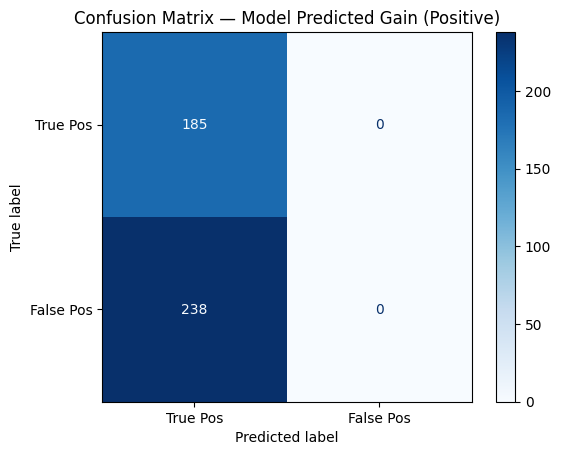

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Convert to binary labels
y_pred = [1] * len(positive_preds_df)  # All predictions are "positive"
y_true = (positive_preds_df["Actual_Return"] > 0).astype(int)  # 1 = TP, 0 = FP

# Step 2: Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["True Pos", "False Pos"])

# Step 3: Plot it
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix — Model Predicted Gain (Positive)")
plt.show()


<ipython-input-40-356e969a5e42>:74: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = df.groupby(["Ticker", "Earnings_Date"]).apply(simulate_trade_with_signals)


<Figure size 600x400 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


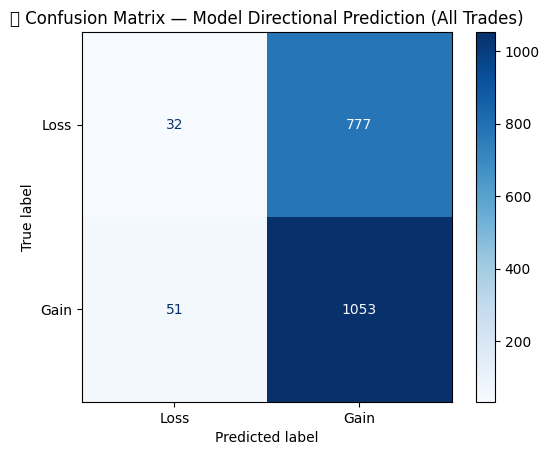


📋 Classification Report:

              precision    recall  f1-score   support

        Loss       0.39      0.04      0.07       809
        Gain       0.58      0.95      0.72      1104

    accuracy                           0.57      1913
   macro avg       0.48      0.50      0.39      1913
weighted avg       0.50      0.57      0.44      1913



In [40]:
# === SETUP ===
!pip install xgboost pandas matplotlib scikit-learn --quiet

import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# === LOAD DATA ===
df = pd.read_csv("strategy_df_window7.csv")  # Change path as needed
df['Date'] = pd.to_datetime(df['Date'])
df['Earnings_Date'] = pd.to_datetime(df['Earnings_Date'])

# === ADD TARGET RETURN COLUMN ===
df['target_pct_change'] = (df['Next_Day_Open'] - df['Close']) / df['Close'] * 100

# === SELECT FEATURES ===
features = [
    'Open', 'Close', 'Regular_Change%', 'After_Hours_Change%',
    'EPS_Actual', 'EPS_Estimate', 'EPS_Surprise', 'EPS_Surprise_%', 'Days_From_Earnings'
]
df = df.dropna(subset=features + ['Next_Day_Open', 'Close'])

# === SPLIT TRAINING SET ===
X = df[features]
y = df['target_pct_change']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# === TRAIN XGBoost MODEL ===
xgb_model = XGBRegressor(n_estimators=50, random_state=42)
xgb_model.fit(X_train, y_train)

# === PREDICT FOR ALL ROWS ===
df["Predicted_Change"] = xgb_model.predict(df[features])

# === SIMULATE TRADES — FIND BEST BUY/SELL IN EACH EARNINGS WINDOW ===
def simulate_trade_with_signals(group):
    best = None
    max_gain = -float('inf')
    rows = group.sort_values("Date").to_dict("records")

    for i, buy in enumerate(rows):
        for j in range(i+1, len(rows)):
            pred_gain = rows[j]['Predicted_Change'] - buy['Predicted_Change']
            actual_return = (rows[j]['Next_Day_Open'] - buy['Close']) / buy['Close'] * 100

            def classify_signal(row):
                ah = row.get('After_Hours_Change%', 0)
                reg = row.get('Regular_Change%', 0)
                if ah > reg:
                    return "After_Hours"
                elif reg > ah:
                    return "Regular"
                else:
                    return "Mixed"

            if pred_gain > max_gain:
                max_gain = pred_gain
                best = {
                    "Ticker": buy["Ticker"],
                    "Earnings_Date": buy["Earnings_Date"],
                    "Buy_Offset": buy["Days_From_Earnings"],
                    "Sell_Offset": rows[j]["Days_From_Earnings"],
                    "Predicted_Gain": pred_gain,
                    "Actual_Return": actual_return,
                    "Buy_Signal_Type": classify_signal(buy),
                    "Sell_Signal_Type": classify_signal(rows[j])
                }
    return best

# === RUN TRADE SIMULATION ===
df = df.sort_values(by=["Ticker", "Earnings_Date", "Date"])
results = df.groupby(["Ticker", "Earnings_Date"]).apply(simulate_trade_with_signals)
trades = [r for r in results if r is not None]
trades_df = pd.DataFrame(trades)

# === SAVE TRADES ===
trades_df.to_csv("xgb_trades_with_signals.csv", index=False)

# === CONFUSION MATRIX: ALL TRADES (Binary Classification) ===
trades_df['Predicted_Label'] = (trades_df['Predicted_Gain'] > 0).astype(int)
trades_df['Actual_Label'] = (trades_df['Actual_Return'] > 0).astype(int)

cm = confusion_matrix(trades_df['Actual_Label'], trades_df['Predicted_Label'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Loss", "Gain"])

plt.figure(figsize=(6, 4))
disp.plot(cmap="Blues", values_format="d")
plt.title("📉 Confusion Matrix — Model Directional Prediction (All Trades)")
plt.show()

# === OPTIONAL: PRINT PRECISION, RECALL, F1 ===
from sklearn.metrics import classification_report
print("\n📋 Classification Report:\n")
print(classification_report(trades_df['Actual_Label'], trades_df['Predicted_Label'], target_names=["Loss", "Gain"]))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:29:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 600x400 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


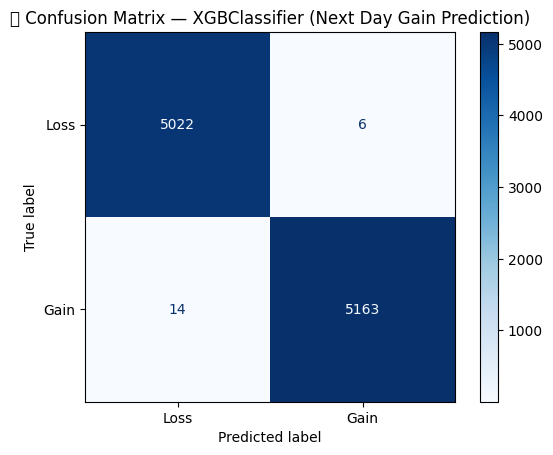


📋 Classification Report:
              precision    recall  f1-score   support

        Loss       1.00      1.00      1.00      5028
        Gain       1.00      1.00      1.00      5177

    accuracy                           1.00     10205
   macro avg       1.00      1.00      1.00     10205
weighted avg       1.00      1.00      1.00     10205



In [41]:
# === SETUP ===
!pip install xgboost pandas matplotlib scikit-learn --quiet

import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# === LOAD YOUR DATA ===
df = pd.read_csv("strategy_df_window7.csv")  # Change to your actual file
df['Date'] = pd.to_datetime(df['Date'])
df['Earnings_Date'] = pd.to_datetime(df['Earnings_Date'])

# === CREATE BINARY TARGET ===
df['Target'] = (df['Next_Day_Open'] > df['Close']).astype(int)

# === SELECT FEATURES ===
features = [
    'Open', 'Close', 'Regular_Change%', 'After_Hours_Change%',
    'EPS_Actual', 'EPS_Estimate', 'EPS_Surprise', 'EPS_Surprise_%', 'Days_From_Earnings'
]
df = df.dropna(subset=features + ['Next_Day_Open', 'Close'])

# === TRAIN/TEST SPLIT ===
X = df[features]
y = df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# === TRAIN CLASSIFIER ===
clf = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.05, use_label_encoder=False, eval_metric='logloss', random_state=42)
clf.fit(X_train, y_train)

# === PREDICT ===
y_pred = clf.predict(X_test)

# === CONFUSION MATRIX ===
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Loss", "Gain"])

plt.figure(figsize=(6, 4))
disp.plot(cmap="Blues", values_format="d")
plt.title("📊 Confusion Matrix — XGBClassifier (Next Day Gain Prediction)")
plt.show()

# === CLASSIFICATION REPORT ===
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Loss", "Gain"]))


<ipython-input-42-98d02fdb9e62>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fi_df, x='Importance', y='Feature', palette='Blues_d')
<ipython-input-42-98d02fdb9e62>:20: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


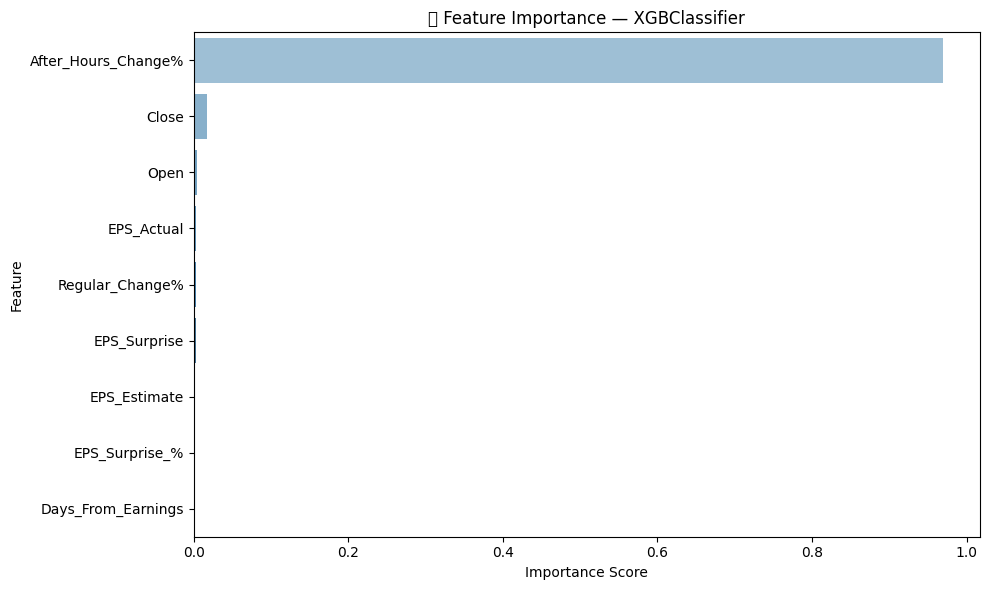

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from trained XGBClassifier
importances = clf.feature_importances_
feature_names = X.columns.tolist()

# Create DataFrame
fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=fi_df, x='Importance', y='Feature', palette='Blues_d')
plt.title("🧠 Feature Importance — XGBClassifier")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:34:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 600x400 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


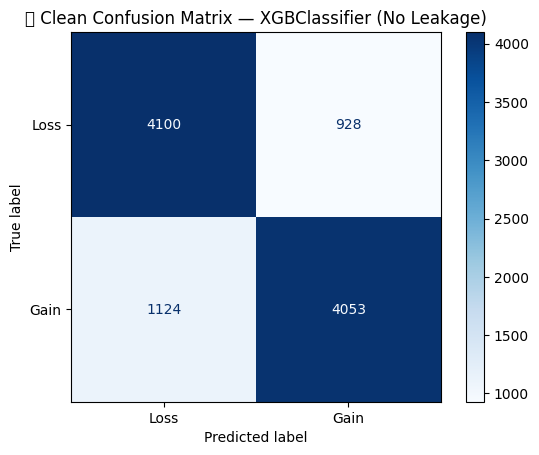

<ipython-input-43-813792038a2d>:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fi_df, x='Importance', y='Feature', palette='Blues_d')


📋 Clean Classification Report:

              precision    recall  f1-score   support

        Loss       0.78      0.82      0.80      5028
        Gain       0.81      0.78      0.80      5177

    accuracy                           0.80     10205
   macro avg       0.80      0.80      0.80     10205
weighted avg       0.80      0.80      0.80     10205



<ipython-input-43-813792038a2d>:61: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


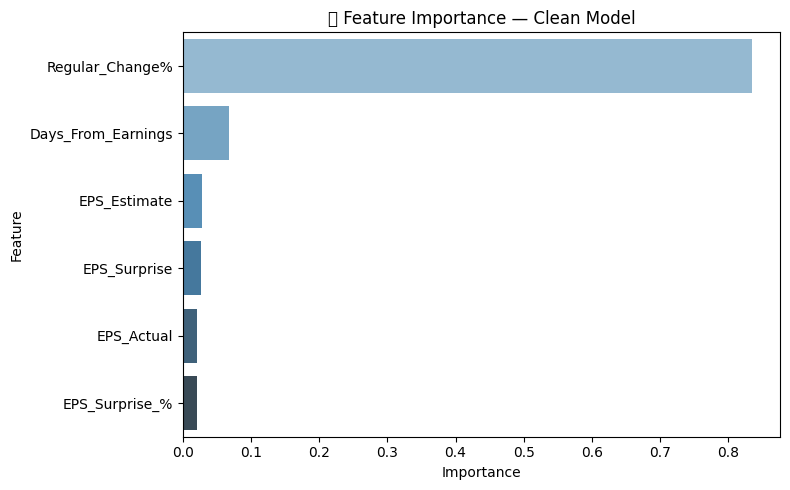

In [43]:
# === SETUP ===
!pip install xgboost pandas matplotlib scikit-learn seaborn --quiet

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# === LOAD DATA ===
df = pd.read_csv("strategy_df_window7.csv")  # Replace with your path

# === CLEAN & TARGET ===
df['Target'] = (df['Next_Day_Open'] > df['Close']).astype(int)
df['Date'] = pd.to_datetime(df['Date'])
df['Earnings_Date'] = pd.to_datetime(df['Earnings_Date'])

# === SAFE FEATURES ONLY (NO LEAKAGE) ===
safe_features = [
    'EPS_Actual', 'EPS_Estimate', 'EPS_Surprise', 'EPS_Surprise_%',
    'Days_From_Earnings', 'Regular_Change%'
]

# Drop rows with missing values in those features
df_clean = df.dropna(subset=safe_features + ['Target'])

X = df_clean[safe_features]
y = df_clean['Target']

# === TRAIN/TEST SPLIT ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# === TRAIN MODEL ===
model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=4,
                      use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# === PREDICTIONS ===
y_pred = model.predict(X_test)

# === CONFUSION MATRIX ===
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Loss", "Gain"])
plt.figure(figsize=(6, 4))
disp.plot(cmap="Blues", values_format="d")
plt.title("🧪 Clean Confusion Matrix — XGBClassifier (No Leakage)")
plt.show()

# === CLASSIFICATION REPORT ===
print("📋 Clean Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["Loss", "Gain"]))

# === FEATURE IMPORTANCE ===
importances = model.feature_importances_
fi_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=fi_df, x='Importance', y='Feature', palette='Blues_d')
plt.title("📊 Feature Importance — Clean Model")
plt.tight_layout()
plt.show()


In [44]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
}

# Initialize model
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Setup GridSearch
grid = GridSearchCV(estimator=xgb, param_grid=param_grid,
                    scoring='f1', cv=3, verbose=1, n_jobs=-1)

# Run tuning
grid.fit(X_train, y_train)

# Results
print("✅ Best Parameters:", grid.best_params_)
print(f"📊 Best F1 Score: {grid.best_score_:.4f}")
best_model = grid.best_estimator_


Fitting 3 folds for each of 36 candidates, totalling 108 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:37:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
📊 Best F1 Score: 0.8048


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:38:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 600x400 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


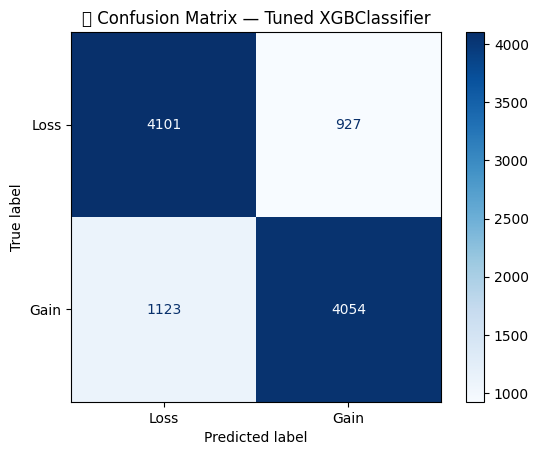

<ipython-input-45-8f8fd050d722>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fi_df, x='Importance', y='Feature', palette='Blues_d')


📋 Tuned Classification Report:

              precision    recall  f1-score   support

        Loss       0.79      0.82      0.80      5028
        Gain       0.81      0.78      0.80      5177

    accuracy                           0.80     10205
   macro avg       0.80      0.80      0.80     10205
weighted avg       0.80      0.80      0.80     10205



<ipython-input-45-8f8fd050d722>:37: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


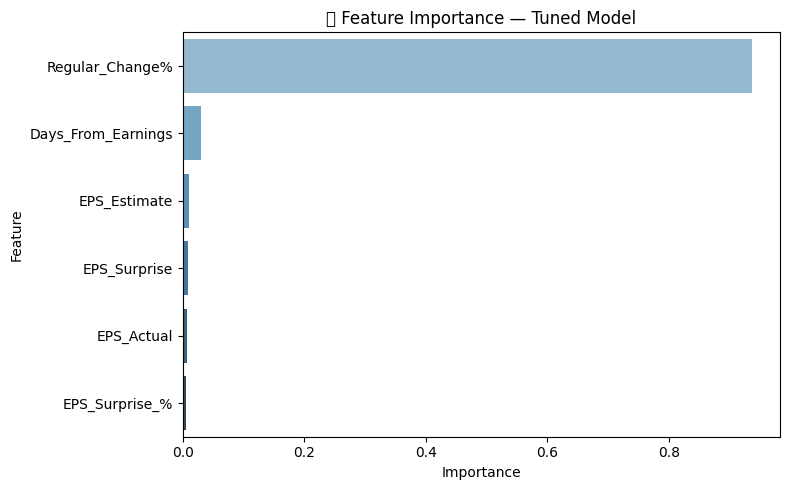

In [45]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# === RETRAIN WITH BEST PARAMS ===
best_model = XGBClassifier(
    learning_rate=0.01,
    max_depth=5,
    n_estimators=100,
    subsample=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)

# === CONFUSION MATRIX ===
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Loss", "Gain"])
plt.figure(figsize=(6, 4))
disp.plot(cmap="Blues", values_format="d")
plt.title("🧪 Confusion Matrix — Tuned XGBClassifier")
plt.show()

# === CLASSIFICATION REPORT ===
print("📋 Tuned Classification Report:\n")
print(classification_report(y_test, y_pred_best, target_names=["Loss", "Gain"]))

# === FEATURE IMPORTANCE (OPTIONAL) ===
importances = best_model.feature_importances_
fi_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=fi_df, x='Importance', y='Feature', palette='Blues_d')
plt.title("📊 Feature Importance — Tuned Model")
plt.tight_layout()
plt.show()


In [46]:
import numpy as np
import pandas as pd

# 🧪 Predict using tuned model
df_test = df.iloc[X_test.index].copy()
df_test['Prediction'] = best_model.predict(X_test)

# ✅ Simulate trades: Buy at close if model says 'Gain'
df_test['Trade_Executed'] = df_test['Prediction'] == 1
df_test['Return_%'] = (df_test['Next_Day_Open'] - df_test['Close']) / df_test['Close'] * 100

# Filter only trades
trade_df = df_test[df_test['Trade_Executed']]

# 📊 Summary stats
total_trades = len(trade_df)
avg_return = trade_df['Return_%'].mean()
cumulative_return = trade_df['Return_%'].sum()

print("📈 Model-Driven Trading Strategy")
print(f"✅ Total Trades: {total_trades}")
print(f"💵 Average Return per Trade: {avg_return:.2f}%")
print(f"📊 Cumulative Return: {cumulative_return:.2f}%")

# Optional: Save trades to CSV
trade_df.to_csv("model_trades_simulated.csv", index=False)


📈 Model-Driven Trading Strategy
✅ Total Trades: 4981
💵 Average Return per Trade: 0.89%
📊 Cumulative Return: 4424.70%


In [53]:
# === STEP 1: Get predicted probabilities ===
probas = best_model.predict_proba(X_test)[:, 1]  # Probability of 'Gain' (label 1)

df_test = df.iloc[X_test.index].copy()
df_test["Predicted_Prob_Gain"] = probas
df_test["Predicted_Label"] = best_model.predict(X_test)

# === STEP 2: Apply confidence threshold ===
CONFIDENCE_THRESHOLD = 0.70
df_test["Trade_Executed"] = df_test["Predicted_Prob_Gain"] > CONFIDENCE_THRESHOLD

# === STEP 3: Simulate returns ===
df_test["Return_%"] = (df_test["Next_Day_Open"] - df_test["Close"]) / df_test["Close"] * 100
confident_trades = df_test[df_test["Trade_Executed"]]

# === STEP 4: Stats ===
total_trades = len(confident_trades)
avg_return = confident_trades["Return_%"].mean()
cumulative_return = confident_trades["Return_%"].sum()

print("🎯 Confidence-Filtered Strategy (Prob > 0.8)")
print(f"✅ Total Trades: {total_trades}")
print(f"💵 Average Return per Trade: {avg_return:.2f}%")
print(f"📊 Cumulative Return: {cumulative_return:.2f}%")

# Optionally export
confident_trades.to_csv("confident_model_trades.csv", index=False)
confident_trades.head()


🎯 Confidence-Filtered Strategy (Prob > 0.8)
✅ Total Trades: 3117
💵 Average Return per Trade: 0.83%
📊 Cumulative Return: 2590.07%


,Ticker,Earnings_Date,Date,Days_From_Earnings,Open,Close,Next_Day_Open,Regular_Change%,After_Hours_Change%,EPS_Actual,...,Industry,Profitable,Founder_is_CEO,FemaleCEO,Growth_in_Jobs,Target,Predicted_Prob_Gain,Predicted_Label,Trade_Executed,Return_%
27986,COST,1999-12-09,1999-12-07,-2,43.062500,42.281250,38.062500,-1.814224,-9.977827,0.28,...,General Merchandisers,yes,no,no,yes,0,0.705824,1,True,-9.977827
11798,JPM,2010-07-15,2010-07-15,0,40.720001,40.459999,40.720001,-0.638512,0.642615,0.73,...,Commercial Banks,yes,no,no,yes,1,0.712312,1,True,0.642615
28098,WBA,2022-03-31,2022-04-01,1,44.540001,43.860001,44.540001,-1.526718,1.550388,1.59,...,Food & Drug Stores,no,no,no,yes,1,0.719264,1,True,1.550388
344,AAPL,2007-07-25,2007-08-01,7,3.070000,3.052500,3.070000,-0.570030,0.573298,0.03,...,"Computers, Office Equipment",yes,no,no,no,1,0.820490,1,True,0.573298
12702,JPM,2003-01-22,2003-01-24,2,24.850000,23.809999,24.850000,-4.185114,4.367917,-0.07,...,Commercial Banks,yes,no,no,yes,1,0.723568,1,True,4.367917


In [54]:
# STEP 1: Predict Probas
probas = best_model.predict_proba(X_test)[:, 1]
df_test = df.iloc[X_test.index].copy()
df_test["Predicted_Prob_Gain"] = probas
df_test["Predicted_Label"] = best_model.predict(X_test)

# STEP 2: Filter Trades with High Confidence
CONFIDENCE_THRESHOLD = 0.80
trades = df_test[df_test["Predicted_Prob_Gain"] > CONFIDENCE_THRESHOLD].copy()

# STEP 3: Calculate Buy/Sell Metrics
trades["Buy_Date"] = trades["Date"]
trades["Sell_Date"] = pd.to_datetime(trades["Date"]) + pd.Timedelta(days=1)
trades["Buy_Price"] = trades["Close"]
trades["Sell_Price"] = trades["Next_Day_Open"]
trades["Return_%"] = (trades["Sell_Price"] - trades["Buy_Price"]) / trades["Buy_Price"] * 100

# Optional Columns
trades["Confidence"] = trades["Predicted_Prob_Gain"]

# STEP 4: Select Relevant Columns
trade_log = trades[[
    "Ticker", "Earnings_Date", "Buy_Date", "Sell_Date",
    "Buy_Price", "Sell_Price", "Return_%", "Confidence"
]]

# Show top 5
print(trade_log.head())

# Save it
trade_log.to_csv("model_confident_trades_log.csv", index=False)


      Ticker Earnings_Date   Buy_Date  Sell_Date   Buy_Price  Sell_Price  \
344     AAPL    2007-07-25 2007-08-01 2007-08-02    3.052500    3.070000   
3928    MSFT    1996-07-22 1996-07-29 1996-07-30    7.304688    7.453125   
12928    JPM    2001-04-18 2001-04-25 2001-04-26   47.480000   47.509998   
28987    WBA    2014-12-23 2014-12-30 2014-12-31   76.050003   76.540001   
26975   COST    2020-09-24 2020-10-01 2020-10-02  297.239990  300.000000   

       Return_%  Confidence  
344    0.573298     0.82049  
3928   2.032079     0.82049  
12928  0.063182     0.82049  
28987  0.644310     0.82049  
26975  0.928546     0.82049  


In [55]:
# Group and summarize trade types
summary = trades_df.groupby(
    ["Buy_Signal_Type", "Sell_Signal_Type", "Prediction_Outcome"]
).agg(
    Count=("Actual_Return", "count"),
    Avg_Actual_Return=("Actual_Return", "mean"),
    Avg_Predicted_Gain=("Predicted_Gain", "mean")
).reset_index()

# Sort for clarity (True Positives on top)
summary = summary.sort_values(by=["Prediction_Outcome", "Avg_Actual_Return"], ascending=[False, False])

# Show result
print(summary)

# Optional: Save to CSV
summary.to_csv("trade_signal_summary.csv", index=False)


KeyError: 'Prediction_Outcome'

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:29:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 600x400 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


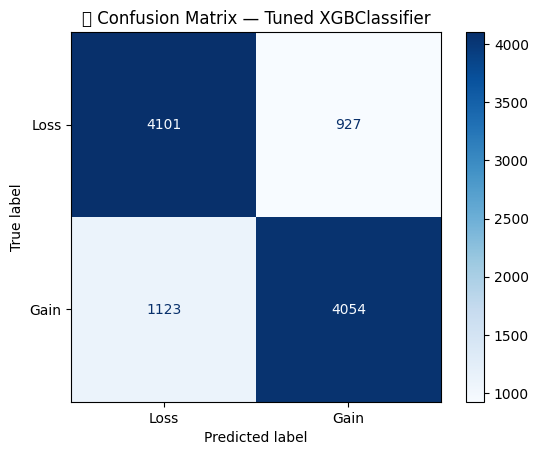

📋 Tuned Classification Report:

              precision    recall  f1-score   support

        Loss       0.79      0.82      0.80      5028
        Gain       0.81      0.78      0.80      5177

    accuracy                           0.80     10205
   macro avg       0.80      0.80      0.80     10205
weighted avg       0.80      0.80      0.80     10205



<ipython-input-56-8b86a3ed737a>:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fi_df, x='Importance', y='Feature', palette='Blues_d')
<ipython-input-56-8b86a3ed737a>:67: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


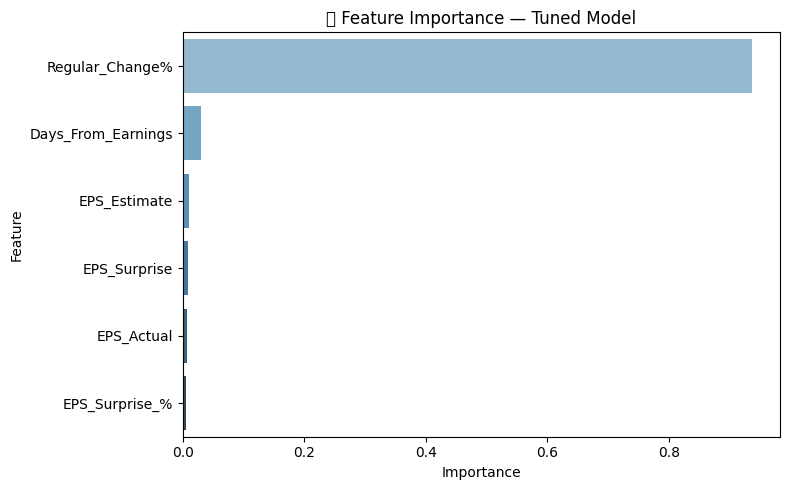

In [56]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# === LOAD DATA ===
df = pd.read_csv("strategy_df_window7.csv")  # Replace with your path

# === CLEAN & TARGET ===
df['Target'] = (df['Next_Day_Open'] > df['Close']).astype(int)
df['Date'] = pd.to_datetime(df['Date'])
df['Earnings_Date'] = pd.to_datetime(df['Earnings_Date'])

# === SAFE FEATURES ONLY (NO LEAKAGE) ===
safe_features = [
    'EPS_Actual', 'EPS_Estimate', 'EPS_Surprise', 'EPS_Surprise_%',
    'Days_From_Earnings', 'Regular_Change%'
]

# Drop rows with missing values in those features
df_clean = df.dropna(subset=safe_features + ['Target'])

X = df_clean[safe_features]
y = df_clean['Target']

# === TRAIN/TEST SPLIT ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# === RETRAIN WITH BEST PARAMS ===
best_model = XGBClassifier(
    learning_rate=0.01,
    max_depth=5,
    n_estimators=100,
    subsample=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)

# === CONFUSION MATRIX ===
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Loss", "Gain"])
plt.figure(figsize=(6, 4))
disp.plot(cmap="Blues", values_format="d")
plt.title("🧪 Confusion Matrix — Tuned XGBClassifier")
plt.show()

# === CLASSIFICATION REPORT ===
print("📋 Tuned Classification Report:\n")
print(classification_report(y_test, y_pred_best, target_names=["Loss", "Gain"]))

# === FEATURE IMPORTANCE (OPTIONAL) ===
importances = best_model.feature_importances_
fi_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=fi_df, x='Importance', y='Feature', palette='Blues_d')
plt.title("📊 Feature Importance — Tuned Model")
plt.tight_layout()
plt.show()


In [81]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# === LOAD AND CLEAN DATA ===
df = pd.read_csv("strategy_df_window7.csv")
df['Target'] = (df['Next_Day_Open'] > df['Close']).astype(int)
df['Date'] = pd.to_datetime(df['Date'])
df['Earnings_Date'] = pd.to_datetime(df['Earnings_Date'])

safe_features = [
    'EPS_Actual', 'EPS_Estimate', 'EPS_Surprise', 'EPS_Surprise_%',
    'Days_From_Earnings', 'Regular_Change%'
]

df_clean = df.dropna(subset=safe_features + ['Target'])
X = df_clean[safe_features]
y = df_clean['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# === TRAIN BEST MODEL ===
best_model = XGBClassifier(
    learning_rate=0.01,
    max_depth=5,
    n_estimators=100,
    subsample=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
best_model.fit(X_train, y_train)

# === PREDICT & PREPARE TRADES ===
probas = best_model.predict_proba(X_test)[:, 1]
df_test = df_clean.iloc[X_test.index].copy()
df_test["Predicted_Prob_Gain"] = probas
df_test["Predicted_Label"] = best_model.predict(X_test)

CONFIDENCE_THRESHOLD = 0.60
trades = df_test[df_test["Predicted_Prob_Gain"] > CONFIDENCE_THRESHOLD].copy()

# === ASSIGN BUY/SELL METRICS ===
trades["Buy_Date"] = trades["Date"]
trades["Sell_Date"] = trades["Date"] + pd.Timedelta(days=1)
trades["Buy_Price"] = trades["Close"]
trades["Sell_Price"] = trades["Next_Day_Open"]
trades["Return_%"] = (trades["Sell_Price"] - trades["Buy_Price"]) / trades["Buy_Price"] * 100

# === CLASSIFY SIGNALS ===
def classify_signal(row):
    ah = row.get("After_Hours_Change%", 0)
    reg = row.get("Regular_Change%", 0)
    if pd.isna(ah) or pd.isna(reg):
        return "Unknown"
    if ah > reg:
        return "After_Hours"
    elif reg > ah:
        return "Regular"
    else:
        return "Mixed"

trades["Buy_Signal_Type"] = trades.apply(classify_signal, axis=1)
trades["Sell_Signal_Type"] = trades["Buy_Signal_Type"]  # For simplicity, carry over type

# === CALCULATE SIGNAL OFFSETS ===
trades["Buy_Offset"] = (trades["Buy_Date"] - trades["Earnings_Date"]).dt.days
trades["Sell_Offset"] = (trades["Sell_Date"] - trades["Earnings_Date"]).dt.days

# === STRATEGY SUMMARY ===
strategy_summary = trades.groupby([
    "Buy_Offset", "Sell_Offset", "Buy_Signal_Type", "Sell_Signal_Type"
]).agg(
    Count=("Ticker", "count"),
    Avg_Actual_Return=("Return_%", "mean"),
    Avg_Predicted_Gain=("Predicted_Prob_Gain", "mean")
).reset_index()

top_strategies = strategy_summary.sort_values(by="Avg_Actual_Return", ascending=False)

# === DISPLAY FINAL STRATEGIES ===
print("📈 Top 10 Model-Informed Trade Strategies:")
top_strategies.head(100)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:06:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📈 Top 10 Model-Informed Trade Strategies:


,Buy_Offset,Sell_Offset,Buy_Signal_Type,Sell_Signal_Type,Count,Avg_Actual_Return,Avg_Predicted_Gain
14,0,1,After_Hours,After_Hours,406,1.684500,0.703402
12,-1,0,After_Hours,After_Hours,311,1.630766,0.703595
28,7,8,After_Hours,After_Hours,294,1.401337,0.820490
6,-4,-3,After_Hours,After_Hours,186,1.346304,0.702175
18,2,3,After_Hours,After_Hours,296,1.337166,0.705717
20,3,4,After_Hours,After_Hours,226,1.334316,0.703693
22,4,5,After_Hours,After_Hours,265,1.304300,0.702048
24,5,6,After_Hours,After_Hours,276,1.282497,0.702778
10,-2,-1,After_Hours,After_Hours,217,1.240751,0.698613
26,6,7,After_Hours,After_Hours,353,1.172730,0.704539


In [84]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

# === LOAD DATA ===
df = pd.read_csv("strategy_df_window7.csv")
df['Date'] = pd.to_datetime(df['Date'])
df['Earnings_Date'] = pd.to_datetime(df['Earnings_Date'])
df['Target'] = (df['Next_Day_Open'] > df['Close']).astype(int)

# === SAFE FEATURES ONLY (NO LEAKAGE) ===
features = [
    'EPS_Actual', 'EPS_Estimate', 'EPS_Surprise', 'EPS_Surprise_%',
    'Days_From_Earnings', 'Regular_Change%'
]
df = df.dropna(subset=features + ['Target'])
X = df[features]
y = df['Target']

# === TRAIN MODEL ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
best_model = XGBClassifier(
    learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8,
    use_label_encoder=False, eval_metric='logloss', random_state=42
)
best_model.fit(X_train, y_train)

# === ADD PREDICTIONS TO DATA ===
df_test = df.iloc[X_test.index].copy()
df_test["Predicted_Prob_Gain"] = best_model.predict_proba(X_test)[:, 1]
df_test["Predicted_Label"] = best_model.predict(X_test)

# === CLASSIFY SIGNALS ===
def classify_signal(row):
    ah = row.get('After_Hours_Change%', 0)
    reg = row.get('Regular_Change%', 0)
    if ah > reg:
        return "After_Hours"
    elif reg > ah:
        return "Regular"
    else:
        return "Mixed"
df_test["Signal_Type"] = df_test.apply(classify_signal, axis=1)

# === STRATEGY ANALYSIS ===
CONFIDENCE_THRESHOLD = 0.7  # You can make this dynamic in dashboard
filtered = df_test[df_test["Predicted_Prob_Gain"] > CONFIDENCE_THRESHOLD].copy()

results = []
for buy_offset in range(-7, 8):
    for sell_offset in range(buy_offset + 1, buy_offset + 3):
        buy = filtered[filtered["Days_From_Earnings"] == buy_offset]
        sell = filtered[filtered["Days_From_Earnings"] == sell_offset]
        for ticker in buy["Ticker"].unique():
            b = buy[buy["Ticker"] == ticker]
            s = sell[sell["Ticker"] == ticker]
            for _, b_row in b.iterrows():
                s_match = s[s["Earnings_Date"] == b_row["Earnings_Date"]]
                for _, s_row in s_match.iterrows():
                    actual_ret = (s_row["Next_Day_Open"] - b_row["Close"]) / b_row["Close"] * 100
                    results.append({
                        "Buy_Offset": buy_offset,
                        "Sell_Offset": sell_offset,
                        "Buy_Signal_Type": b_row["Signal_Type"],
                        "Sell_Signal_Type": s_row["Signal_Type"],
                        "Actual_Return": actual_ret,
                        "Predicted_Gain": b_row["Predicted_Prob_Gain"]
                    })

# === GROUP & RANK STRATEGIES ===
res_df = pd.DataFrame(results)
summary = res_df.groupby(
    ["Buy_Offset", "Sell_Offset", "Buy_Signal_Type", "Sell_Signal_Type"]
).agg(
    Count=('Actual_Return', 'count'),
    Avg_Actual_Return=('Actual_Return', 'mean'),
    Avg_Predicted_Gain=('Predicted_Gain', 'mean')
).reset_index()

top_strategies = summary.sort_values(by="Avg_Actual_Return", ascending=False).head(15)
print("\n📈 Top Model-Informed Trade Strategies:")
top_strategies.head(10)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:15:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



📈 Top Model-Informed Trade Strategies:


,Buy_Offset,Sell_Offset,Buy_Signal_Type,Sell_Signal_Type,Count,Avg_Actual_Return,Avg_Predicted_Gain
32,-2,0,After_Hours,Regular,2,9.534923,0.713121
62,3,5,After_Hours,After_Hours,8,7.261196,0.711813
16,-5,-3,After_Hours,After_Hours,3,6.124840,0.710675
22,-4,-2,Regular,After_Hours,2,5.266976,0.703509
75,5,7,After_Hours,After_Hours,32,5.040287,0.709895
53,1,3,After_Hours,Regular,2,3.356878,0.708128
20,-4,-2,After_Hours,After_Hours,12,3.301946,0.711497
60,3,4,After_Hours,After_Hours,14,3.236098,0.711394
63,3,5,Regular,After_Hours,3,3.085270,0.713037
31,-2,0,After_Hours,After_Hours,30,2.749890,0.711741


In [101]:
def generate_trade_strategies(strategy_df, best_model, confidence_threshold=0.8, window_size=9, top_n=15):
    import pandas as pd

    df = strategy_df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df['Earnings_Date'] = pd.to_datetime(df['Earnings_Date'])

    # 1. Define target and clean features
    df['Target'] = (df['Next_Day_Open'] > df['Close']).astype(int)
    features = ['EPS_Actual', 'EPS_Estimate', 'EPS_Surprise', 'EPS_Surprise_%', 'Days_From_Earnings', 'Regular_Change%']
    df = df.dropna(subset=features + ['Target'])

    # 2. Predict with model
    X_all = df[features]
    df["Predicted_Prob_Gain"] = best_model.predict_proba(X_all)[:, 1]
    df["Predicted_Label"] = best_model.predict(X_all)

    # 3. Filter high-confidence predictions
    confident_df = df[df["Predicted_Prob_Gain"] >= confidence_threshold].copy()

    # 4. Signal classifier
    def classify_signal(row):
        ah = row.get('After_Hours_Change%', 0)
        reg = row.get('Regular_Change%', 0)
        if ah > reg:
            return "After_Hours"
        elif reg > ah:
            return "Regular"
        else:
            return "Mixed"

    confident_df["Signal_Type"] = confident_df.apply(classify_signal, axis=1)

    strategies = []

    # 5. Loop through offsets
    for buy_offset in range(-window_size, window_size):
        for sell_offset in range(buy_offset + 1, window_size + 1):
            buy_rows = confident_df[confident_df["Days_From_Earnings"] == buy_offset].copy()
            sell_rows = confident_df[confident_df["Days_From_Earnings"] == sell_offset].copy()

            if buy_rows.empty or sell_rows.empty:
                continue

            merged = pd.merge(
                buy_rows, sell_rows,
                on=["Ticker", "Earnings_Date"],
                suffixes=("_buy", "_sell")
            )

            if merged.empty:
                continue

            merged["Actual_Return"] = (
                (merged["Next_Day_Open_sell"] - merged["Close_buy"]) / merged["Close_buy"]
            ) * 100

            merged["Buy_Signal_Type"] = merged["Signal_Type_buy"]
            merged["Sell_Signal_Type"] = merged["Signal_Type_sell"]
            merged["Buy_Offset"] = buy_offset
            merged["Sell_Offset"] = sell_offset

            grouped = merged.groupby(
                ["Buy_Offset", "Sell_Offset", "Buy_Signal_Type", "Sell_Signal_Type"]
            ).agg({
                "Actual_Return": "mean",
                "Predicted_Prob_Gain_buy": "mean",
                "Ticker": "count"
            }).reset_index()

            grouped.columns = [
                "Buy_Offset", "Sell_Offset", "Buy_Signal_Type", "Sell_Signal_Type",
                "Avg_Actual_Return", "Avg_Predicted_Gain", "Count"
            ]

            strategies.append(grouped)

    if not strategies:
        return pd.DataFrame()

    final = pd.concat(strategies, ignore_index=True)
    final = final.sort_values(by="Avg_Actual_Return", ascending=False)
    return final.head(top_n)


In [103]:
# Run this with strategy_df and best_model
df = pd.read_csv("strategy_df_window7.csv")
top_strats_classifier = generate_trade_strategies(df, best_model, confidence_threshold=0.7, window_size=7, top_n=10)
print("📈 Top Model-Informed Trade Strategies:")
top_strats_classifier.head(20)


📈 Top Model-Informed Trade Strategies:


,Buy_Offset,Sell_Offset,Buy_Signal_Type,Sell_Signal_Type,Avg_Actual_Return,Avg_Predicted_Gain,Count
29,-7,1,Regular,Regular,12.785395,0.711843,1
172,-4,4,Regular,Regular,7.435573,0.712762,2
82,-6,3,Regular,After_Hours,7.255507,0.712365,12
195,-3,2,After_Hours,After_Hours,7.078240,0.710356,52
133,-5,5,Regular,After_Hours,6.815416,0.709139,11
49,-7,7,Regular,After_Hours,6.323151,0.712558,22
145,-4,-2,After_Hours,After_Hours,6.307837,0.711366,99
132,-5,5,After_Hours,Regular,5.914518,0.709722,11
140,-5,7,Regular,After_Hours,5.098548,0.714059,31
237,-2,4,After_Hours,Regular,5.091900,0.710508,16


In [104]:
def generate_trade_strategies(strategy_df, best_model, confidence_threshold=0.8, window_size=9, top_n=15):
    import pandas as pd

    df = strategy_df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df['Earnings_Date'] = pd.to_datetime(df['Earnings_Date'])

    # 1. Define regression target
    df['Target'] = ((df['Next_Day_Open'] - df['Close']) / df['Close']) * 100
    features = ['EPS_Actual', 'EPS_Estimate', 'EPS_Surprise', 'EPS_Surprise_%', 'Days_From_Earnings', 'Regular_Change%']
    df = df.dropna(subset=features + ['Target'])

    # 2. Predict gains
    X_all = df[features]
    df["Predicted_Gain"] = best_model.predict(X_all)

    # 3. Filter for predicted gains above threshold
    confident_df = df[df["Predicted_Gain"] >= confidence_threshold].copy()

    # 4. Signal classifier
    def classify_signal(row):
        ah = row.get('After_Hours_Change%', 0)
        reg = row.get('Regular_Change%', 0)
        if ah > reg:
            return "After_Hours"
        elif reg > ah:
            return "Regular"
        else:
            return "Mixed"

    confident_df["Signal_Type"] = confident_df.apply(classify_signal, axis=1)

    strategies = []

    # 5. Combine offsets
    for buy_offset in range(-window_size, window_size):
        for sell_offset in range(buy_offset + 1, window_size + 1):
            buy_rows = confident_df[confident_df["Days_From_Earnings"] == buy_offset].copy()
            sell_rows = confident_df[confident_df["Days_From_Earnings"] == sell_offset].copy()

            if buy_rows.empty or sell_rows.empty:
                continue

            merged = pd.merge(
                buy_rows, sell_rows,
                on=["Ticker", "Earnings_Date"],
                suffixes=("_buy", "_sell")
            )

            if merged.empty:
                continue

            merged["Actual_Return"] = (
                (merged["Next_Day_Open_sell"] - merged["Close_buy"]) / merged["Close_buy"]
            ) * 100

            merged["Buy_Signal_Type"] = merged["Signal_Type_buy"]
            merged["Sell_Signal_Type"] = merged["Signal_Type_sell"]
            merged["Buy_Offset"] = buy_offset
            merged["Sell_Offset"] = sell_offset

            grouped = merged.groupby(
                ["Buy_Offset", "Sell_Offset", "Buy_Signal_Type", "Sell_Signal_Type"]
            ).agg({
                "Actual_Return": "mean",
                "Predicted_Gain_buy": "mean",
                "Ticker": "count"
            }).reset_index()

            grouped.columns = [
                "Buy_Offset", "Sell_Offset", "Buy_Signal_Type", "Sell_Signal_Type",
                "Avg_Actual_Return", "Avg_Predicted_Gain", "Count"
            ]

            strategies.append(grouped)

    if not strategies:
        return pd.DataFrame()

    final = pd.concat(strategies, ignore_index=True)
    final = final.sort_values(by="Avg_Actual_Return", ascending=False)
    return final.head(top_n)


In [105]:
# Run this with strategy_df and best_model
df = pd.read_csv("strategy_df_window7.csv")
top_strats_regressor = generate_trade_strategies(df, best_model, confidence_threshold=0.7, window_size=7, top_n=10)
print("📈 Top Model-Informed Trade Strategies:")
top_strats_regressor.head(20)

📈 Top Model-Informed Trade Strategies:


,Buy_Offset,Sell_Offset,Buy_Signal_Type,Sell_Signal_Type,Avg_Actual_Return,Avg_Predicted_Gain,Count
45,-7,4,Regular,Regular,16.912146,1.0,7
164,-4,-2,After_Hours,After_Hours,8.710360,1.0,156
128,-5,0,Mixed,After_Hours,8.552855,1.0,1
113,-5,-3,After_Hours,After_Hours,7.651174,1.0,181
191,-4,4,Regular,Regular,7.435573,1.0,2
207,-3,-1,Mixed,Regular,6.993007,1.0,1
89,-6,2,Regular,Regular,5.661681,1.0,5
361,2,4,After_Hours,Regular,5.630029,1.0,11
95,-6,4,After_Hours,Regular,4.861102,1.0,20
152,-5,5,Regular,Regular,4.748521,1.0,1


In [109]:
df_classifier_renamed = top_strats_classifier.rename(columns={
    "Avg_Actual_Return": "Avg_Actual_Return_Classifier",
    "Avg_Predicted_Gain": "Avg_Predicted_Gain_Classifier"
})

df_regressor_renamed = top_strats_regressor.rename(columns={
    "Avg_Actual_Return": "Avg_Actual_Return_Regressor",
    "Avg_Predicted_Gain": "Avg_Predicted_Gain_Regressor"
})



# === Merge and Compare ===
comparison_df = pd.merge(
    df_classifier_renamed,
    df_regressor_renamed,
    on=["Buy_Offset", "Sell_Offset", "Buy_Signal_Type", "Sell_Signal_Type"],
    how="outer"
)

# Show the merged comparison
print("\n🔍 Classifier vs Regressor — Strategy Comparison:\n")
comparison_df.sort_values(by="Avg_Actual_Return_Regressor", ascending=False).head(15)



🔍 Classifier vs Regressor — Strategy Comparison:



,Buy_Offset,Sell_Offset,Buy_Signal_Type,Sell_Signal_Type,Avg_Actual_Return_Classifier,Avg_Predicted_Gain_Classifier,Count_x,Avg_Actual_Return_Regressor,Avg_Predicted_Gain_Regressor,Count_y
1,-7,4,Regular,Regular,NaN,NaN,NaN,16.912146,1.0,7.0
12,-4,-2,After_Hours,After_Hours,6.307837,0.711366,99.0,8.710360,1.0,156.0
7,-5,0,Mixed,After_Hours,NaN,NaN,NaN,8.552855,1.0,1.0
6,-5,-3,After_Hours,After_Hours,NaN,NaN,NaN,7.651174,1.0,181.0
13,-4,4,Regular,Regular,7.435573,0.712762,2.0,7.435573,1.0,2.0
14,-3,-1,Mixed,Regular,NaN,NaN,NaN,6.993007,1.0,1.0
3,-6,2,Regular,Regular,NaN,NaN,NaN,5.661681,1.0,5.0
17,2,4,After_Hours,Regular,NaN,NaN,NaN,5.630029,1.0,11.0
5,-6,4,After_Hours,Regular,NaN,NaN,NaN,4.861102,1.0,20.0
10,-5,5,Regular,Regular,NaN,NaN,NaN,4.748521,1.0,1.0


In [97]:
X_train.shape[0]

23809

In [98]:
X_test.shape[0]

10205